<a href="https://colab.research.google.com/github/sharmita01/gsoc_ml4sc_cern/blob/main/Jets_clf_GNN_PointNet_task4a_Dey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Jet classification PointNet architecture: task 4, architecture I


In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

     |████████████████████████████████| 2.6MB 31.6MB/s 
     |████████████████████████████████| 1.5MB 43.5MB/s 
     |████████████████████████████████| 1.0MB 25.1MB/s 
     |████████████████████████████████| 194kB 17.9MB/s 
     |████████████████████████████████| 235kB 38.9MB/s 
     |████████████████████████████████| 2.2MB 53.2MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 


Parts of the notebook has been adapted from the GNN PyTorch Geometric tutotials

##Get data

In [ ]:
#mount Google drive
from google.colab import drive
import numpy as np
drive.mount("/content/drive")

data = np.load('/content/drive/My Drive/graph_NN_datastets_jet_clf/QG_jets_1.npz')

Mounted at /content/drive


## Training inputs and training labels


In [ ]:
data_X = data['X']
data_y = data['y']

In [ ]:
print (data_X.shape)
print (data_y.shape)

(100000, 134, 4)
(100000,)


##Constructing edge indexes for point cloud data




torch.Size([2, 2187])


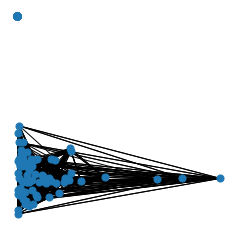

In [ ]:
import torch
from torch_cluster import knn_graph

data_x_0_edge_idx = knn_graph(torch.tensor(data_X[0]), k=16)
print(data_x_0_edge_idx.shape)
visualize_points(data_X[0], edge_index=data_x_0_edge_idx)

In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(PointNetLayer, self).__init__('max')
        # the number of input features = hidden node dim + point dim, where point dim = 4, i.e., ( pt, rapidity, azimuthal angle, and pdgid.)
        print (in_channels)
        self.fc = Sequential(Linear(in_channels + 4, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        #print('h_j',h_j.shape)
        #print ('pos_j',pos_j.shape)
        #print ('pos_i',pos_i.shape)
        # h_j : features of neighboring nodes --> shape [num_edges, in_channels]
        # pos_j: position of neighboring nodes --> shape [num_edges, 4]
        # pos_i: position of central nodes --> shape [num_edges, 4]

        input = pos_j - pos_i  # spatial relation.

        if h_j is not None:
            input = torch.cat([h_j, input], dim=-1)

        return self.fc(input)  

In [ ]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        torch.manual_seed(42)
        self.conv1 = PointNetLayer(4, 64)
        self.conv2 = PointNetLayer(64, 32)
        self.classifier = Linear(32, 2) #num_classes = 2, i.e, Quark or Gluon
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        edge_index = torch.tensor(knn_graph(pos, k=16, batch=batch, loop=True))

        # 3. bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch) 
        
        # 5. Classifier.
        return self.classifier(h)


## Training

In [ ]:
from torch_geometric.data import Data, DataLoader

train_data_list =  [Data(pos=torch.tensor(data_X[i]), 
                         y=torch.tensor(data_y[i])) for i in range(8000)]
print(len(train_data_list))
test_data_list = [Data(pos=torch.tensor(data_X[i]), 
                       y=torch.tensor(data_y[i])) for i in range(8000, 10000)]

train_loader = DataLoader(train_data_list, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=10)

model = PointNet() #initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #optimizer
loss_func = torch.nn.CrossEntropyLoss()  # loss function.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data_ in loader:
        optimizer.zero_grad()  
        #print(data_.batch)
        pred = model(data_.pos.float(), data_.batch)  # forward pass.
        loss = loss_func(pred, data_.y.long())  # compute loss
        loss.backward()  # backward pass.
        optimizer.step()  # Update model params.
        total_loss += loss.item() * data_.num_graphs

    return total_loss / len(train_loader.dataset)


def test(model, loader):
    model.eval()
    with torch.no_grad():

      total_correct = 0
      for data in loader:
          pred = model(data.pos.float(), data.batch)
          pred = pred.argmax(dim=-1)
          total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 20):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

8000
4
64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01, Loss: 0.8783, Test Accuracy: 0.7445
Epoch: 02, Loss: 0.5384, Test Accuracy: 0.7150
Epoch: 03, Loss: 0.5584, Test Accuracy: 0.7285
Epoch: 04, Loss: 0.5492, Test Accuracy: 0.7305
Epoch: 05, Loss: 0.5476, Test Accuracy: 0.7415
Epoch: 06, Loss: 0.5555, Test Accuracy: 0.7410
Epoch: 07, Loss: 0.5548, Test Accuracy: 0.7490
Epoch: 08, Loss: 0.5543, Test Accuracy: 0.7245
Epoch: 09, Loss: 0.5737, Test Accuracy: 0.7165
Epoch: 10, Loss: 0.5652, Test Accuracy: 0.7185
Epoch: 11, Loss: 0.5671, Test Accuracy: 0.7085
Epoch: 12, Loss: 0.5589, Test Accuracy: 0.7350
Epoch: 13, Loss: 0.5565, Test Accuracy: 0.6935
Epoch: 14, Loss: 0.5630, Test Accuracy: 0.7425
Epoch: 15, Loss: 0.5462, Test Accuracy: 0.7330
Epoch: 16, Loss: 0.5602, Test Accuracy: 0.7230
Epoch: 17, Loss: 0.5696, Test Accuracy: 0.7365
Epoch: 18, Loss: 0.5590, Test Accuracy: 0.7310
Epoch: 19, Loss: 0.5705, Test Accuracy: 0.7350


The max multiplicity, M=134 is considered as the nodes for constructing the edge indices,  where 4 is the dimensionality representation of each node, i.e.,  pt, rapidity, 
azimuthal angle, and pdgid.